In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from zodbpickle import pickle
from IPython.display import display
import time
pd.set_option('display.max_columns', 100)
%matplotlib inline

# Load Data

# Sampling (stratified 1:1)

# Raw data (preliminarily processed) Checkpoint

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import display
from zodbpickle import pickle
pd.set_option('display.max_columns', 100)
%matplotlib inline

data_train_stf = pd.DataFrame.from_csv('../data/data_train_stf.csv')
data_test = pd.DataFrame.from_csv('../data/data_test_all.csv')

In [7]:
from preliminary_proc import drop_plus_date_rows

data_train_stf = drop_plus_date_rows(data_train_stf)
data_test = drop_plus_date_rows(data_test)

# Begin Feature Engineering
## Plan A -- using data_train_stf

In [10]:
# Reset shuffled indices
data_train_stf.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [11]:
feature_train, feature_test = data_train_stf.drop('isinvested', axis=1), data_test.drop('isinvested', axis=1)
label_train, label_test = data_train_stf.isinvested, data_test.isinvested
user_id_test = data_test.user_id

In [12]:
# Join back for data preprocessing
feature_all_df = feature_train.append(feature_test, ignore_index=True)

### Determine columns-to-drop

In [14]:
def drop_columns(df):
#     drop_useless_cols = ['user_id', 'mobile', 'pno']
#     drop_might_be_useful_cols = ['channel_id', 'create_date_id', 'create_time', 'areacode', 'devicetype']
#     drop_future_cols = ['date_id', 'invest_time', 'active_num', 'lastday_before_invest', 'lianxuday_last', 'rate']
#     drop_alter_label = ['plus_date']
#     drop_call_cols = ['callstatus', 'call_effec', 'gap_calltoinvest', 'last_calltime',
#            'call_times', 'isactive_aftercall']
#     drop_other_cols = ['etl_time']

#     drop_total = list(set(drop_useless_cols + drop_might_be_useful_cols + drop_future_cols + drop_alter_label + drop_call_cols + drop_other_cols))
#     print(len(drop_total))
# #     print(len(drop_useless_cols) + len(drop_might_be_useful_cols) + len(drop_future_cols), len(drop_alter_label), len(drop_call_cols), len(drop_other_cols), len(drop_total))
#     df_modified = df.drop(drop_total, axis=1)
# #     print("{} cols dropped.".format(len(cols_to_drop_tuple)))

# #     Drop the stay-series, to be added back
# #     stay_list = [x for x in df.columns if 'stay' in x and x not in ['staynum', 'staytime']]
# #     df_modified = df.drop(stay_list, axis=1)
#     df_modified = df_modified.iloc[:, :10]
    
#     return df_modified
    keep_col = ['user_age', 'sex_id', 'client_type_id', 'isrecharged', 'rechargestatus',
       'isinvited', 'lastday_invite', 'lastamt_invite', 'staytime', 'staynum']
#     keep_col = ['user_age', 'sex_id', 'client_type_id', 'isrecharged', 'rechargestatus',
#        'isinvited', 'lastday_invite', 'lastamt_invite']
    return df.loc[:, keep_col]

In [15]:
feature_all_dropped = drop_columns(feature_all_df)

In [16]:
feature_all_dropped.shape

(143019, 10)

In [17]:
def speedy_process(df, cat_colnames):
    # Process numeric features
    for colname in set(df.columns).difference(set(cat_colnames)):
        # Create NA indicator
        df[colname + '_na'] = df[colname].isnull().astype(int)
        # Fill NA using median
#         df[colname] = df[colname].fillna(df[colname].median())
        df[colname] = df[colname].fillna(0)
#         # Normalization
#         df[colname] = (df[colname] - df[colname].min()) / (df[colname].max() - df[colname].min())
        
    # Process categorical features
    for cat_colname in cat_colnames:
        one_hot_df = pd.get_dummies(df[cat_colname], prefix=cat_colname, drop_first=True, dummy_na=False)
#         one_hot_df = pd.get_dummies(df[cat_colname], prefix=cat_colname, drop_first=True, dummy_na=True)
        df = df.join(one_hot_df)
        df.drop([cat_colname], axis=1, inplace=True)
    
    return df

In [18]:
feature_all_proc = speedy_process(feature_all_dropped, cat_colnames=['sex_id', 'client_type_id', 
                                                        'isrecharged', 'rechargestatus', 'isinvited'])

In [19]:
feature_all_proc.head()

,user_age,lastday_invite,lastamt_invite,staytime,staynum,lastday_invite_na,staytime_na,lastamt_invite_na,user_age_na,staynum_na,sex_id_1,sex_id_2,client_type_id_2,client_type_id_3,client_type_id_6,isrecharged_1,rechargestatus_0.0,rechargestatus_1.0,isinvited_1
0,19.0,0.0,0.0,298.0,37,1,0,1,0,0,1,0,0,1,0,0,0,0,0
1,53.0,0.0,0.0,0.0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0
2,43.0,4.0,50000.0,806.0,72,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,22.0,0.0,0.0,728.0,103,1,0,1,0,0,0,1,0,1,0,0,0,0,0
4,22.0,1.0,100.0,422.0,30,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [20]:
feature_train = feature_all_proc.iloc[:len(feature_train), :]
feature_test = feature_all_proc.iloc[len(feature_train):, :]

In [21]:
# Convert labels
label_dict = {'未投资': 0, '已投资': 1}

label_train.replace(label_dict, inplace=True)
label_test.replace(label_dict, inplace=True)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature_train, label_train, test_size=0.30, random_state=13)

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=13)
clf_dt.fit(X_train, y_train)

sorted_importance = sorted(list(zip(X_train.columns, clf_dt.feature_importances_)), key=lambda x: x[1], reverse=True)

for x in sorted_importance:
    print(x)

('staytime', 0.32834637276553602)
('user_age', 0.3151695512501852)
('staynum', 0.21550970438465888)
('client_type_id_2', 0.031498093304595409)
('client_type_id_3', 0.022025319561475055)
('isinvited_1', 0.020584559495529269)
('sex_id_1', 0.012836032766469349)
('lastday_invite', 0.011427358475658516)
('client_type_id_6', 0.0087990045722841203)
('isrecharged_1', 0.0085890910719438312)
('lastamt_invite', 0.0068412079467727359)
('sex_id_2', 0.0067755574101299792)
('staytime_na', 0.0037425926781061566)
('rechargestatus_0.0', 0.0031591859250125489)
('lastday_invite_na', 0.0021569531807655324)
('rechargestatus_1.0', 0.0017812453241555122)
('lastamt_invite_na', 0.00075816988672196034)
('user_age_na', 0.0)
('staynum_na', 0.0)


In [24]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()

# from sklearn.ensemble import RandomForestRegressor

start_time = time.time()

clf = RandomForestClassifier(n_estimators=512, min_samples_leaf=25, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=13)
# param_grid = {'n_estimators': [128, 256, 512, 1024], 'min_samples_leaf': [25, 50, 100]}
# cls_gs = GridSearchCV(cls, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
# clf.fit(X_train, np.asarray(y_train, dtype="|S6"))
print("Training took {} seconds.".format(time.time() - start_time))



Training took 2.2226319313049316 seconds.


In [25]:
y_pred_train = clf.predict_proba(X_train)
y_pred_val = clf.predict_proba(X_val)

In [26]:
def calc_ks(data, n, prediction="prediction", label="label"):
    """
    calculate ks value
    :param data: DataFrame[prediction,label]
    :param n : int number of cut
    :param prediction: string name of prediction
    :param label: string name of label
    :return: array
    """
    data = data.sort_values(prediction, ascending=False)
    boolean = True
    while boolean:
        try:
            data[prediction] = pd.Series(pd.qcut(data[prediction], n, labels=np.arange(n).astype(str)))
        except ValueError:
            boolean = True
            n -= 1
        else:
            boolean = False
    count = data.groupby(prediction)[label].agg({'bad': np.count_nonzero, 'obs': np.size})
    count["good"] = count["obs"] - count["bad"]
    t_bad = np.sum(count["bad"])
    t_good = np.sum(count["good"])
    ks_vector = np.abs(np.cumsum(count["bad"]) / t_bad - np.cumsum(count["good"]) / t_good)
    return ks_vector

def calc_continus_ks(data, prediction="prediction", label="label"):
    """

    :param data:
    :param prediction:
    :param label:
    :return:
    """
    data = data.sort_values(prediction, ascending=False)
    count = data.groupby(prediction, sort=False)[label].agg({'bad': np.count_nonzero, 'obs': np.size})
    count["good"] = count["obs"] - count["bad"]
    t_bad = np.sum(count["bad"])
    t_good = np.sum(count["good"])
    ks_vector = np.abs(np.cumsum(count["bad"]) / t_bad - np.cumsum(count["good"]) / t_good)
    return ks_vector

def eval_ks(y_true, y_pred):
    target_oos = y_pred
#     rf_results = pd.DataFrame({'prediction':target_oos[:, 1],"label":y_true})
    rf_results = pd.DataFrame({'prediction':target_oos,"label":y_true})
    ks_dis = calc_ks(rf_results, 10, prediction="prediction")
#     print(max(ks_dis))
    ks_cont = calc_continus_ks(rf_results, prediction="prediction")
#     print(max(ks_cont))
    return max(ks_dis), max(ks_cont)

In [27]:
def draw_decile_chart(df, bin_var, target, bins=10):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from math import ceil
    
    df_temp = df.copy()
    chart_df = df_temp.loc[:, list(set([bin_var] + target))]
    chart_df_sorted = chart_df.sort_values(bin_var)
    
    bin_col = []
    bin_size = ceil(len(chart_df_sorted) / bins)
    element_counter = 0
    bin_num = bins
    
    for i in range(len(chart_df_sorted)):
        bin_col.append(bin_num)
        element_counter += 1
        
        if element_counter == bin_size:
            bin_num -= 1
            element_counter = 0
    
    bin_col_name = bin_var + '_bin'
    chart_with_bin_df = chart_df_sorted.copy()
    chart_with_bin_df[bin_col_name] = bin_col

    bin_index = chart_with_bin_df.groupby(bin_col_name).mean().index
    grouped_by_age_bin = chart_with_bin_df.groupby(bin_col_name)
    display(grouped_by_age_bin.mean())
    
    for x in target:
        plt.plot(bin_index, grouped_by_age_bin.mean()[x], linestyle='-')
    
    plt.legend()

In [28]:
print(eval_ks(y_train, y_pred_train[:, 1]))

/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(0.67210876833803779, 0.67379973904349688)


,Prediction,Label
Prediction_bin,,
1,0.931399,0.993147
2,0.877657,0.958926
3,0.768549,0.828331
4,0.651175,0.679305
5,0.547700,0.565034
6,0.442712,0.416008
7,0.304119,0.230648
8,0.138336,0.028963
9,0.033208,0.000000


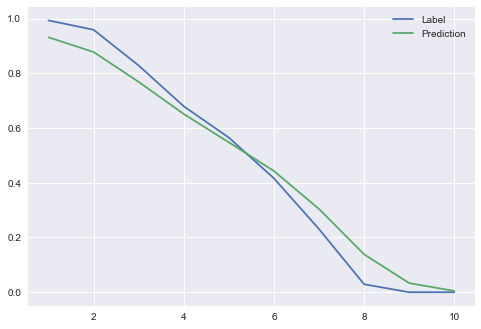

In [29]:
decile_train = pd.DataFrame({'Label': y_train, 'Prediction': y_pred_train[:, 1]})
draw_decile_chart(decile_train, 'Prediction', ['Label', 'Prediction'], bins=10)

In [30]:
print(eval_ks(y_val, y_pred_val[:, 1]))

(0.64660627771839541, 0.65276352726683384)


/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


,Prediction,Label
Prediction_bin,,
1,0.931746,0.982780
2,0.879470,0.958231
3,0.769683,0.825553
4,0.649661,0.700246
5,0.542071,0.528256
6,0.442260,0.457002
7,0.306518,0.270270
8,0.145191,0.041769
9,0.035259,0.000000


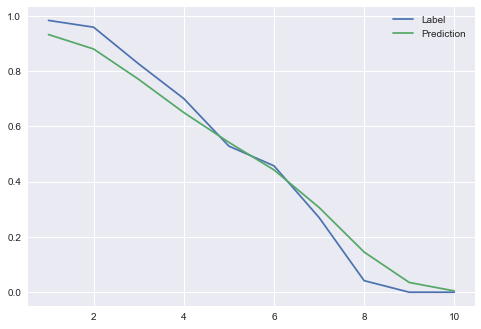

In [31]:
decile_val = pd.DataFrame({'Label': y_val, 'Prediction': y_pred_val[:, 1]})
draw_decile_chart(decile_val, 'Prediction', ['Label', 'Prediction'], bins=10)

# Finally, on to the test set (OOS)

In [32]:
y_pred = clf.predict_proba(feature_test)

In [33]:
print(eval_ks(label_test, y_pred[:, 1]))

/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/finup/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:36: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(0.66187381832953884, 0.66962427648109335)


In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(label_test, y_pred[:, 1])

0.92409906309396816

In [35]:
decile_df = pd.DataFrame({'Label': label_test, 'Prediction': y_pred[:, 1]})

,Prediction,Label
Prediction_bin,,
1,0.777617,0.315576
2,0.578354,0.076186
3,0.465263,0.043054
4,0.356623,0.023469
5,0.241357,0.011475
6,0.130332,0.001639
7,0.088284,0.000173
8,0.011502,0.000000
9,0.005462,0.000000


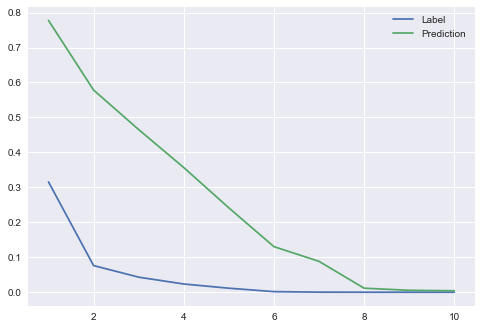

In [36]:
draw_decile_chart(decile_df, 'Prediction', ['Label', 'Prediction'], bins=10)